# **EDA - IMÁGENES MÉDICAS (.nii)**

In [1]:
# [Config] Librerías
import pandas as pd
import os
import nibabel as nib
import re
import numpy as np
import pandas as pd
from datetime import datetime
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# [Config] Rutas
df = pd.read_csv("../Datos/Clinical/ADNI_Images.csv")


In [3]:
df['EXAMDATE'] = pd.to_datetime(df['EXAMDATE'], errors='coerce')

mapa_viscode = {'bl':0, "m06": 6,"m12": 12,"m18": 18,"m24": 24, 'm30': 30, "m36": 36}
df["VISCODE"] = df["VISCODE"].map(mapa_viscode)

def categorizar_educacion(anios):
    if anios <= 10:
        return "Primaria o menos"
    elif anios <= 12:
        return "Secundaria completa"
    elif anios <= 14:
        return "Técnico o incompleto universitario"
    elif anios <= 16:
        return "Universitario completo"
    elif anios <= 18:
        return "Posgrado corto"
    else:
        return "Posgrado avanzado"
df["PTEDUCAT"] = df["PTEDUCAT"].apply(categorizar_educacion)

## **1. Descripción del conjunto de datos**

In [4]:
# []
print("-" * 30)
print("📁 Información general:")
print(f"\nDimensión: {df.shape[0]} Imágenes disponibles × {df.shape[1]} atributos")
print(f"\nTipo de atributos: \n{df.dtypes.value_counts()}")
print("-" * 30)
print(f"👦 {df['sujeto_id'].nunique()} sujetos en estudio")

------------------------------
📁 Información general:

Dimensión: 279 Imágenes disponibles × 35 atributos

Tipo de atributos: 
float64           22
object            11
int64              1
datetime64[ns]     1
Name: count, dtype: int64
------------------------------
👦 51 sujetos en estudio


In [5]:
print("-" * 30)
print("📁 Valores nulos:")
print(f"Variables con valores nulos:")
nulos = df.isna().sum()
porcentaje = (nulos / len(df)) * 100
tabla_nulos = pd.DataFrame({
    "Variable": nulos.index,
    "Cantidad_nulos": nulos.values,
    "Porcentaje_nulos": porcentaje.round(2)
})
tabla_nulos = tabla_nulos[tabla_nulos["Cantidad_nulos"] > 0]
tabla_nulos = tabla_nulos.sort_values(by="Cantidad_nulos", ascending=False).reset_index(drop=True)
tabla_nulos

------------------------------
📁 Valores nulos:
Variables con valores nulos:


Variable  Cantidad_nulos  Porcentaje_nulos
0        Hippocampus              67             24.01
1            MidTemp              67             24.01
2           Fusiform              67             24.01
3         Entorhinal              67             24.01
4                ICV              38             13.62
5         WholeBrain              38             13.62
6         Ventricles              38             13.62
7                FAQ              31             11.11
8           TRABSCOR              31             11.11
9   RAVLT_forgetting              30             10.75
10             CDRSB              30             10.75
11         DIGITSCOR              29             10.39
12    RAVLT_learning              29             10.39
13   RAVLT_immediate              29             10.39
14            ADAS13              29             10.39
15              MMSE              28             10.04
16                DX              28             10.04

In [6]:
# DX con valores nulos
print("-" * 30)
print("📁 DX con valores nulos:")
print(f"Registros con DX nulos: {df['DX'].isna().sum()}")
porcentaje_nulo = df["DX"].isna().mean() * 100
print(f"{porcentaje_nulo:.2f}% de los registros no tienen DX asignado.")
df_dx_nulo = df[df["DX"].isna()]
print(f"Diagnosticos nulos en las vistas: {df_dx_nulo['VISCODE'].unique()}")
print("-" * 30)
print(df_dx_nulo[["sujeto_id", "VISCODE", "EXAMDATE", "DX"]])



------------------------------
📁 DX con valores nulos:
Registros con DX nulos: 28
10.04% de los registros no tienen DX asignado.
Diagnosticos nulos en las vistas: [30]
------------------------------
      sujeto_id  VISCODE   EXAMDATE   DX
5    007_S_0101       30 2008-07-18  NaN
12   007_S_0128       30 2008-08-20  NaN
18   007_S_0249       30 2008-10-01  NaN
29   014_S_0169       30 2008-09-16  NaN
48   018_S_0142       30 2008-08-20  NaN
54   018_S_0155       30 2008-10-06  NaN
60   021_S_0141       30 2008-09-09  NaN
72   021_S_0273       30 2008-10-13  NaN
78   021_S_0276       30 2008-10-01  NaN
84   022_S_0004       30 2008-05-08  NaN
90   023_S_0042       30 2008-06-24  NaN
97   023_S_0126       30 2008-10-23  NaN
104  027_S_0116       30 2008-08-18  NaN
115  027_S_0256       30 2008-10-16  NaN
122  027_S_0307       30 2008-10-30  NaN
134  032_S_0214       30 2008-10-16  NaN
147  035_S_0204       30 2008-09-26  NaN
157  037_S_0150       30 2008-09-10  NaN
178  067_S_0176       

17 variables clínicas tienen nulos; las volumétricas (Hippocampus, Fusiform, Entorhinal, MidTemp) tienen ~23.7% nulos; ICV/WholeBrain/Ventricles ~13.4%; scores cognitivos ~10%.

28 registros con DX nulo (~9.9%).

## **2. Propiedades técnicas de las imágenes**

In [7]:
# [] Formato de imagen - Orientación - Tipo de dato y unidades
shape_counts = df["shape"].value_counts() #Formatos de imagen
orint_counts = df["orientation"].value_counts() #Orientación espacial

tabla_shape= pd.DataFrame({
    "Shape": shape_counts.index,
    "Imágenes": shape_counts.values
})

tabla_orientarion= pd.DataFrame({
    "Orientación": orint_counts.index,
    "Imágenes": orint_counts.values
})

print("\nFormatos de imagen:")
print(tabla_shape)

print("\nOrientación:")
print(tabla_orientarion)

print(f"\nTipos de datos {df['datatype'].unique()} \nUnidades {df['units'].unique()}") #Tipo de dato y unidades



Formatos de imagen:
             Shape  Imágenes
0  (160, 192, 192)        99
1  (166, 256, 256)        89
2  (180, 256, 256)        35
3  (256, 256, 170)        34
4  (256, 256, 184)         9
5  (170, 256, 256)         6
6  (160, 240, 256)         4
7  (176, 256, 256)         1
8  (170, 288, 288)         1
9  (162, 256, 256)         1

Orientación:
       Orientación  Imágenes
0  ('R', 'A', 'S')       236
1  ('P', 'S', 'R')        43

Tipos de datos ['int16'] 
Unidades ["('mm', 'sec')"]


In [8]:
# Resoluciones de voxel
voxel_counts = df["voxel_size"].value_counts()
volumen_counts = df["voxel_volume_mm3"].value_counts()
total_counts = df["total_volume"].value_counts()

tabla_voxel= pd.DataFrame({
    "Voxel": voxel_counts.index,
    "Imágenes": voxel_counts.values
})
tabla_volum= pd.DataFrame({
    "Volumen": volumen_counts.index,
    "Imágenes": volumen_counts.values
})
tabla_total= pd.DataFrame({
    "Volumen total": total_counts.index,
    "Imágenes": total_counts.values
})

print("\nResoluciones de voxel:")
print(tabla_voxel)
print("\nVolumen de voxel:")
print(tabla_volum)
print("\nVolumen estimado:")
print(tabla_total)


Resoluciones de voxel:
                          Voxel  Imágenes
0         (1.2, 0.9375, 0.9375)       113
1             (1.2, 1.25, 1.25)        97
2         (0.9375, 0.9375, 1.2)        41
3   (1.1998978, 0.9375, 0.9375)         6
4               (1.2, 1.0, 1.0)         4
5   (1.1996994, 0.9375, 0.9375)         3
6   (1.1996002, 0.9375, 0.9375)         3
7         (1.2, 0.9766, 0.9766)         1
8   (1.2, 0.8680556, 0.8680556)         1
9   (0.9765625, 0.9765625, 1.2)         1
10        (1.1999999, 1.0, 1.0)         1
11              (1.0, 1.0, 1.2)         1
12    (1.2, 0.976562, 0.976562)         1
13  (1.1996994, 0.9766, 0.9766)         1
14  (1.2001953, 0.9375, 0.9375)         1
15  (1.2003021, 0.9375, 0.9375)         1
16  (1.2, 1.2760416, 1.2760416)         1
17  (1.2, 1.3020834, 1.3020834)         1
18   (1.199884, 0.9375, 0.9375)         1

Volumen de voxel:
     Volumen  Imágenes
0   1.054688       154
1   1.875000        97
2   1.054598         6
3   1.200000         5
4 

Qué significa cada código?
- 'R', 'L': Right / Left (derecha / izquierda)
- 'A', 'P': Anterior / Posterior (frontal / trasera)
- 'S', 'I': Superior / Inferior (arriba / abajo)
Por ejemplo:
- ('R', 'A', 'S'): Ejes orientados hacia la derecha, adelante y arriba.
- ('P', 'S', 'R'): Ejes hacia atrás, arriba y derecha — diferente orden y dirección.


In [9]:
# Intensidad de imagen
print("Intensidad de la imagen")
print("-" * 30)
# Brillo
resumen_mean = df['mean_intensity'].describe().round(2).to_frame(name='mean_intensity')
resumen_mean.index.name = 'Brillo'
print(resumen_mean)
print("-" * 30)
# Contraste
resumen_std = df['std_intensity'].describe().round(2).to_frame(name='std_intensity')
resumen_std.index.name = 'Contraste'
print(resumen_std)

Intensidad de la imagen
------------------------------
        mean_intensity
Brillo                
count           279.00
mean          32013.94
std           71216.46
min              11.66
25%             101.73
50%             127.50
75%             274.09
max          363261.17
------------------------------
           std_intensity
Contraste               
count             279.00
mean            47971.67
std            107668.61
min                16.62
25%               132.22
50%               168.22
75%               369.50
max            579786.68


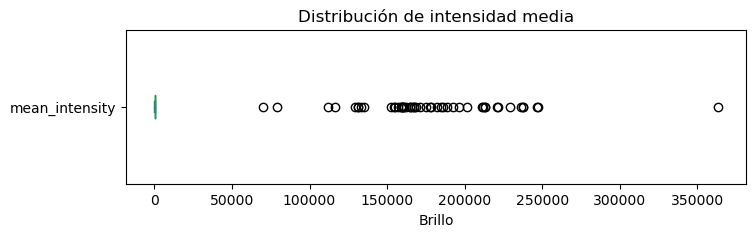

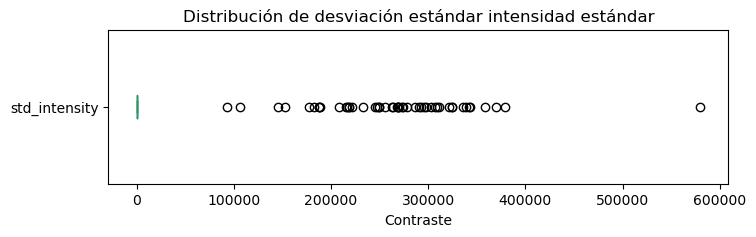

In [10]:
plt.figure(figsize=(8, 2))
df['mean_intensity'].plot.box(vert=False)
plt.title("Distribución de intensidad media")
plt.xlabel("Brillo")

plt.figure(figsize=(8, 2))
df['std_intensity'].plot.box(vert=False)
plt.title("Distribución de desviación estándar intensidad estándar")
plt.xlabel("Contraste")
plt.show()

In [11]:
# Configuración mayoritaria de las imágenes
variables = {
    "shape": df["shape"],
    "orientation": df["orientation"],
    "voxel_size": df["voxel_size"],
    "voxel_volume_mm3": df["voxel_volume_mm3"],
    "total_volume": df["total_volume"]
}

# Construir tabla resumen
resumen = []

for nombre, serie in variables.items():
    valor_frecuente = serie.value_counts().idxmax()
    cantidad_frecuente = serie.value_counts().max()
    cantidad_diferente = (serie != valor_frecuente).sum()
    
    resumen.append({
        "Variable": nombre,
        "Más frecuente": valor_frecuente,
        "Cantidad": cantidad_frecuente,
        "Diferentes": cantidad_diferente
    })

tabla_resumen = pd.DataFrame(resumen)
print(tabla_resumen)

           Variable          Más frecuente  Cantidad  Diferentes
0             shape        (160, 192, 192)        99         180
1       orientation        ('R', 'A', 'S')       236          43
2        voxel_size  (1.2, 0.9375, 0.9375)       113         166
3  voxel_volume_mm3               1.054688       154         125
4      total_volume             11059200.0        97         182


In [12]:
# Imágenes con brillo y contraste outliers
def detectar_outliers_iqr(serie, nombre_columna):
    """
    Devuelve un DataFrame con los valores outliers de una columna numérica según el método IQR.
    """
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    outliers = (serie < limite_inferior) | (serie > limite_superior)
    print(f"🔹{nombre_columna}: {outliers.sum()} outliers detectados")
    return outliers

df["outlier_mean_intensity"] = detectar_outliers_iqr(df["mean_intensity"], "mean_intensity")
df["outlier_std_intensity"] = detectar_outliers_iqr(df["std_intensity"], "std_intensity")

# Etiqueta combinada de calidad
df["calidad_intensidad"] = "ok"
df.loc[df["outlier_mean_intensity"], "calidad_intensidad"] = "outlier_media"
df.loc[df["outlier_std_intensity"], "calidad_intensidad"] = "outlier_contraste"
df.loc[df["outlier_mean_intensity"] & df["outlier_std_intensity"], "calidad_intensidad"] = "outlier_ambos"



🔹mean_intensity: 50 outliers detectados
🔹std_intensity: 50 outliers detectados


In [13]:
# Puntaje de calidad 

shape_fr = df["shape"].value_counts().idxmax()
orien_fr = df["orientation"].value_counts().idxmax()
voxel_fr = df["voxel_size"].value_counts().idxmax()
volum_fr = df["voxel_volume_mm3"].value_counts().idxmax()
total_fr = df["total_volume"].value_counts().idxmax()

# Criterios de calidad
df["fail_shape"] = df["shape"] != shape_fr
df["fail_orientation"] = df["orientation"] != orien_fr
df["fail_voxel_size"] = df["voxel_size"] != voxel_fr
df["fail_voxel_volume"] = df["voxel_volume_mm3"] != volum_fr
df["fail_total_volume"] = df["total_volume"] != total_fr

# Outliers de intensidad
def detectar_outliers_iqr(serie):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    return (serie < Q1 - 1.5 * IQR) | (serie > Q3 + 1.5 * IQR)

df["fail_mean_intensity"] = detectar_outliers_iqr(df["mean_intensity"])
df["fail_std_intensity"] = detectar_outliers_iqr(df["std_intensity"])

# Puntaje total de fallos por imagen
df["puntaje_calidad"] = (
    df["fail_shape"].astype(int) +
    df["fail_orientation"].astype(int) +
    df["fail_voxel_size"].astype(int) +
    df["fail_voxel_volume"].astype(int) +
    df["fail_total_volume"].astype(int) +
    df["fail_mean_intensity"].astype(int) +
    df["fail_std_intensity"].astype(int)
)
resumen_puntajes = df["puntaje_calidad"].value_counts().sort_index()
print(" Distribución de puntajes de calidad:")
resumen_puntajes= pd.DataFrame({
    "Puntaje": resumen_puntajes.index,
    "Imágenes": resumen_puntajes.values
})
print(resumen_puntajes)

 Distribución de puntajes de calidad:
   Puntaje  Imágenes
0        2       205
1        3         2
2        4        27
3        6        43
4        7         2


% Los puntajes de calidad indican que tan corrupta esta una imagen

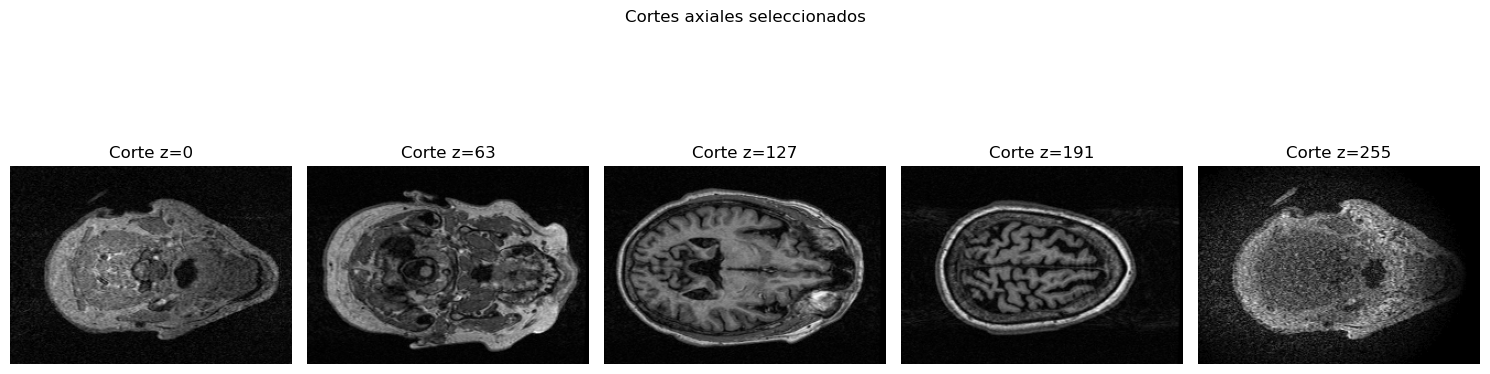

In [15]:

# Cargar imagen
img = nib.load(r"C:\Users\Hp\MACHINE\MRI\Datos\IMAGES\021_S_0273\MP-RAGE\2006-03-14_10_55_38.0\I11942\ADNI_11M4_BC_4.nii")
data = img.get_fdata()

# Seleccionar 5 cortes equiespaciados en el eje axial (z)
num_cortes = 5
indices = np.linspace(0, data.shape[2] - 1, num_cortes, dtype=int)

# Mostrar los cortes
plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    plt.subplot(1, num_cortes, i + 1)
    plt.imshow(data[:, :, idx], cmap="gray")
    plt.title(f"Corte z={idx}")
    plt.axis("off")

plt.suptitle("Cortes axiales seleccionados")
plt.tight_layout()
plt.show()


## **2. Sobre el paciente**

In [16]:
# Crear DataFrame resumen por sujeto
info_sujetos = df.groupby('sujeto_id').agg({
    'AGE': 'mean',         # Edad
    'PTGENDER': 'first',   # género
    'PTEDUCAT': 'first',   # educación
    'DX': 'last',
    'APOE4': 'first',
}).reset_index()

------------------------------
Edades de los pacientes
count    51.000000
mean     74.525490
std       6.904574
min      60.300000
25%      70.200000
50%      75.200000
75%      79.500000
max      88.300000
Name: AGE, dtype: float64


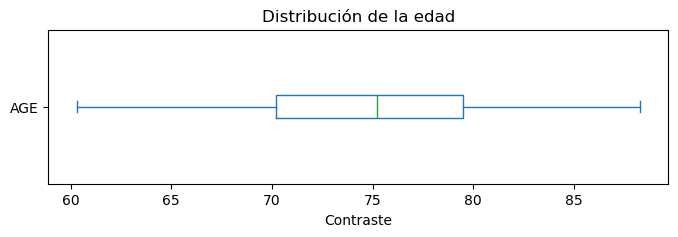

In [17]:
# EDADES
print("-"*30)
print("Edades de los pacientes")
print(info_sujetos['AGE'].describe())
plt.figure(figsize=(8, 2))
info_sujetos['AGE'].plot.box(vert=False)
plt.title("Distribución de la edad")
plt.xlabel("Contraste")
plt.show()

------------------------------
Sexo de los pacientes
          count
PTGENDER       
Male         38
Female       13


<Axes: ylabel='PTGENDER'>

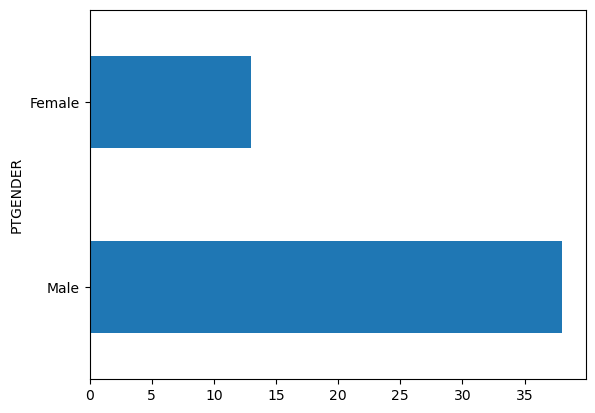

In [18]:
# SEXO
print("-"*30)
print("Sexo de los pacientes")
print(info_sujetos['PTGENDER'].value_counts().to_frame())
info_sujetos['PTGENDER'].value_counts().plot.barh()

------------------------------
Nivel educativo de los pacientes
                                    count
PTEDUCAT                                 
Universitario completo                 16
Posgrado corto                         12
Posgrado avanzado                      11
Técnico o incompleto universitario      5
Secundaria completa                     4
Primaria o menos                        3


<Axes: ylabel='PTEDUCAT'>

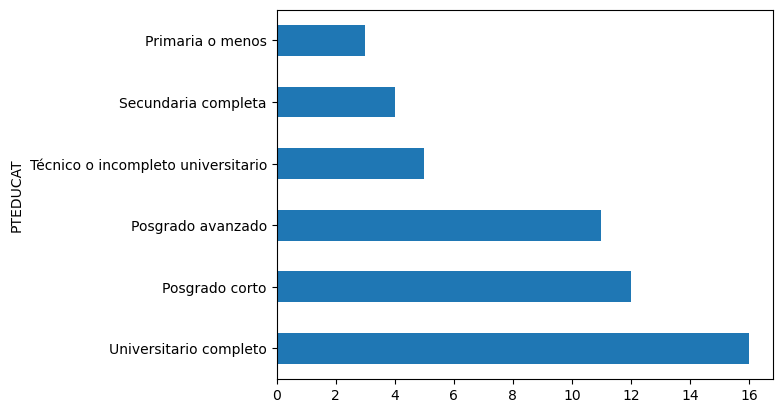

In [19]:
# Educación
print("-"*30)
print("Nivel educativo de los pacientes")
print(info_sujetos['PTEDUCAT'].value_counts().to_frame())
info_sujetos['PTEDUCAT'].value_counts().plot.barh()

------------------------------
Genotipo APOE4
       count
APOE4       
0.0       23
1.0       22
2.0        6


<Axes: ylabel='APOE4'>

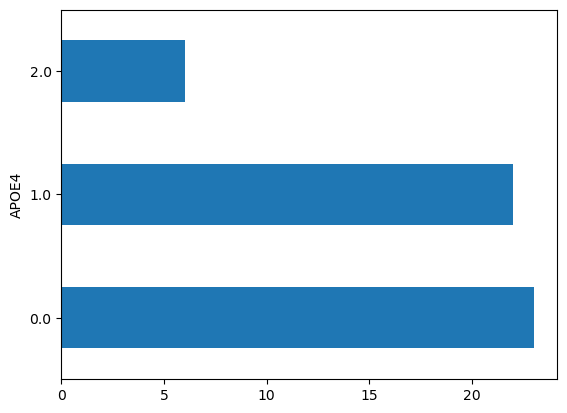

In [20]:
# Educación
print("-"*30)
print("Genotipo APOE4")
print(info_sujetos['APOE4'].value_counts().to_frame())
info_sujetos['APOE4'].value_counts().plot.barh()

------------------------------
Genotipo DX
          count
DX             
MCI          29
Dementia     22


<Axes: ylabel='DX'>

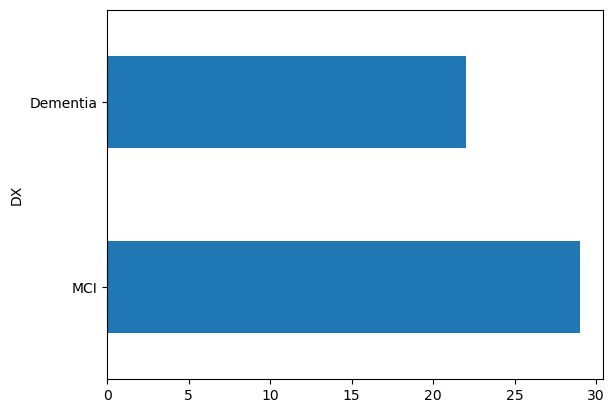

In [21]:
# Diagnóstico final
print("-"*30)
print("Genotipo DX")
print(info_sujetos['DX'].value_counts().to_frame())
info_sujetos['DX'].value_counts().plot.barh()

% mejorar graficos  e interpretacion

                count
duracion_anios       
1                  12
2                  22
3                  16
4                   1


<Axes: ylabel='duracion_anios'>

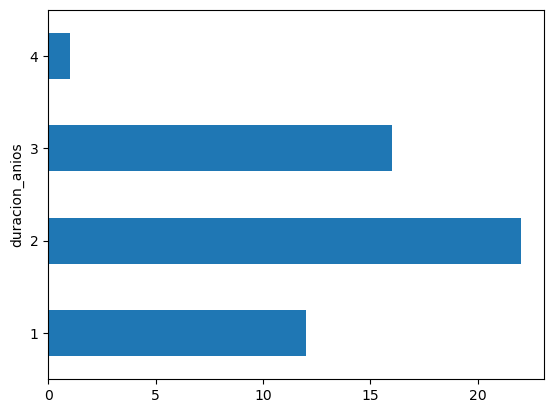

In [22]:
df["EXAMDATE"] = pd.to_datetime(df["EXAMDATE"])
df["año"] = df["EXAMDATE"].dt.year
df_duracion = df.sort_values(["sujeto_id", "EXAMDATE"]).groupby("sujeto_id").agg(
    año_inicio=("año", "first"),
    año_final=("año", "last")
).reset_index()

df_duracion["duracion_anios"] = df_duracion["año_final"] - df_duracion["año_inicio"]
print(df_duracion["duracion_anios"].value_counts().sort_index().to_frame())

df_duracion["duracion_anios"].value_counts().sort_index().plot.barh()

## **3. Progresión clínica**

   Vistas  Pacientes
0       3          6
1       4          7
2       5         10
3       6         13
4       7         15
Resumen de número de visitas por paciente:


Text(0, 0.5, 'Frecuencia')

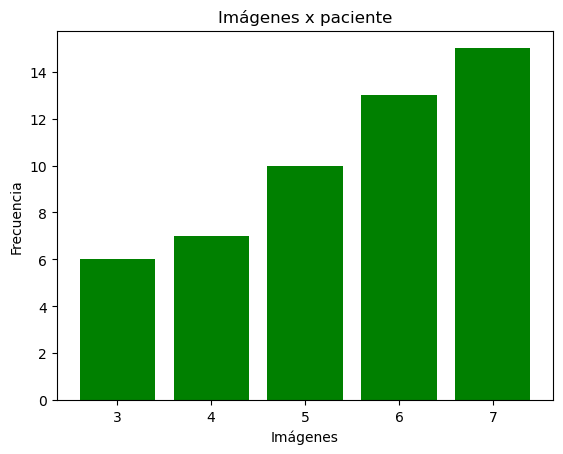

In [23]:
# Vistas por pacientes
tabla_visitas = (
    df
    .assign(valor="O")  # marcamos presencia
    .pivot_table(index="sujeto_id", columns="VISCODE", values="valor", aggfunc="first", fill_value="X")
    .sort_index(axis=1)
)
tabla_visitas
conteo_visitas = (tabla_visitas == "O").sum(axis=1)
resumen_visitas = conteo_visitas.value_counts().sort_index()
tabla_resumen = pd.DataFrame({
    "Vistas": resumen_visitas.index,
    "Pacientes": resumen_visitas.values
})
print(tabla_resumen)
print("Resumen de número de visitas por paciente:")
plt.bar(tabla_resumen["Vistas"], tabla_resumen["Pacientes"], color='green')
plt.title("Imágenes x paciente")
plt.xlabel("Imágenes")
plt.ylabel("Frecuencia")

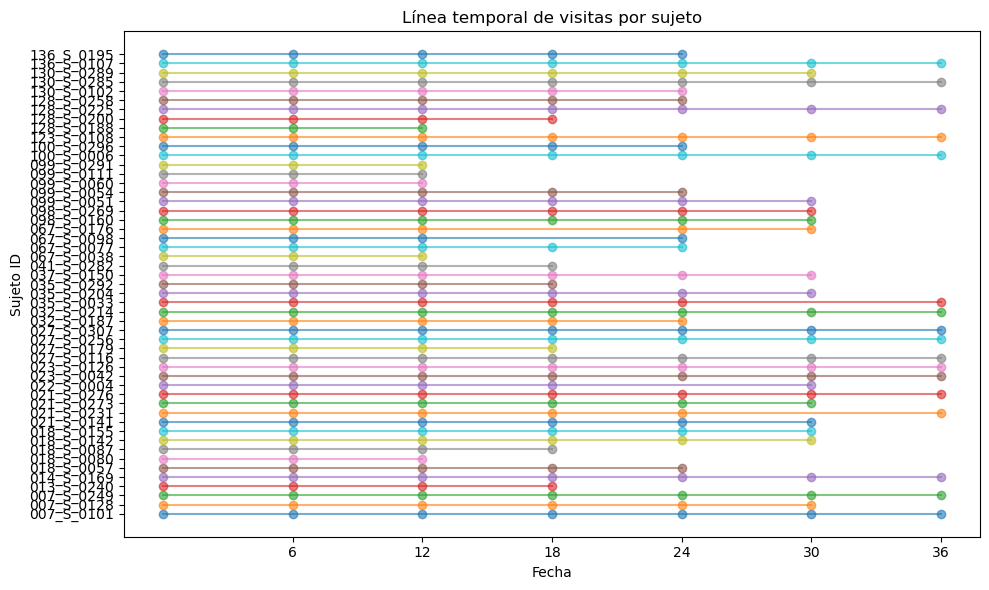

In [24]:
# Linea de vistas por sujeto
plt.figure(figsize=(10,6))
for sid, grupo in df.groupby('sujeto_id'):
    plt.plot(grupo['VISCODE'], [sid]*len(grupo), marker='o', linestyle='-', alpha=0.6)
plt.title('Línea temporal de visitas por sujeto')
plt.xticks(ticks=range(6, 37, 6))
plt.xlabel('Fecha')
plt.ylabel('Sujeto ID')
plt.tight_layout()
plt.show()


% Grafico importantisimo

         count
VISCODE       
0           51
6           51
12          51
18          43
24          38
30          28
36          17


<Axes: ylabel='VISCODE'>

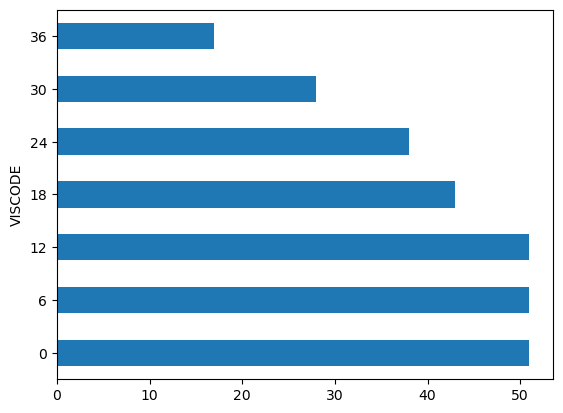

In [25]:
print(df["VISCODE"].value_counts().sort_index().to_frame())
df['VISCODE'].value_counts().sort_index().plot.barh()

* Variables sobre el estado cognitivo
% Buscar que significa cada cosa

In [26]:
# Variables cognitivas
info_cognitiva = df.groupby('sujeto_id').agg({
    'CDRSB': ['min', 'mean', 'max'],
    'MMSE': ['min', 'mean', 'max'],
    'ADAS13': ['min', 'mean', 'max'],
    'FAQ': ['min', 'mean', 'max'],
    'RAVLT_immediate':['min', 'mean', 'max'],
    'RAVLT_learning': ['min', 'mean', 'max'],
    'RAVLT_forgetting': ['min', 'mean', 'max'],
    'DIGITSCOR': ['min', 'mean', 'max'],
    'TRABSCOR': ['min', 'mean', 'max'],
}).reset_index()


C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


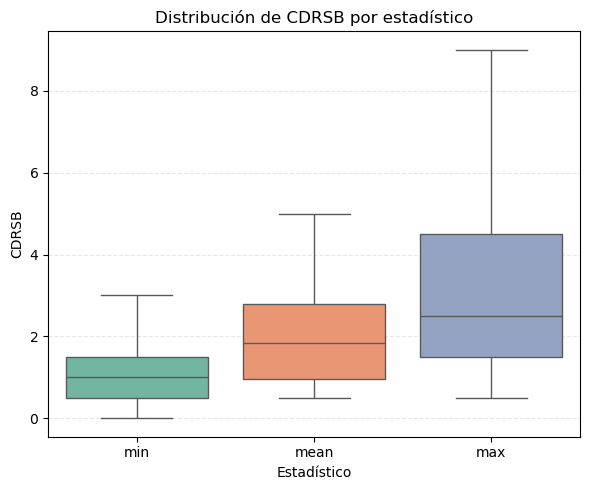

C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


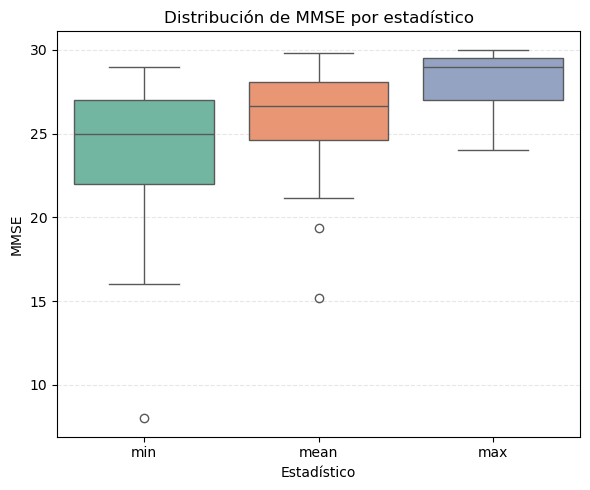

C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


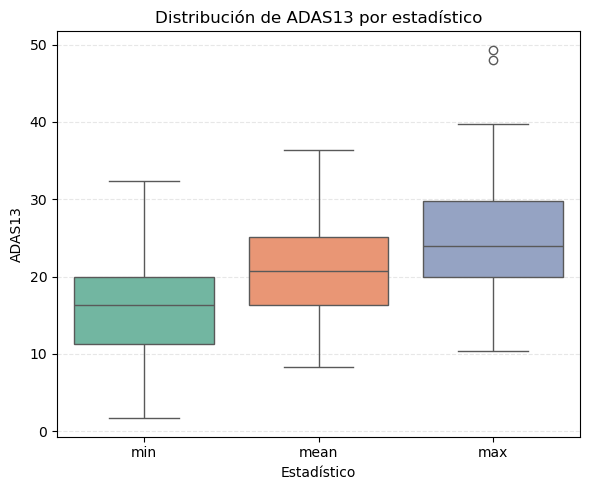

C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


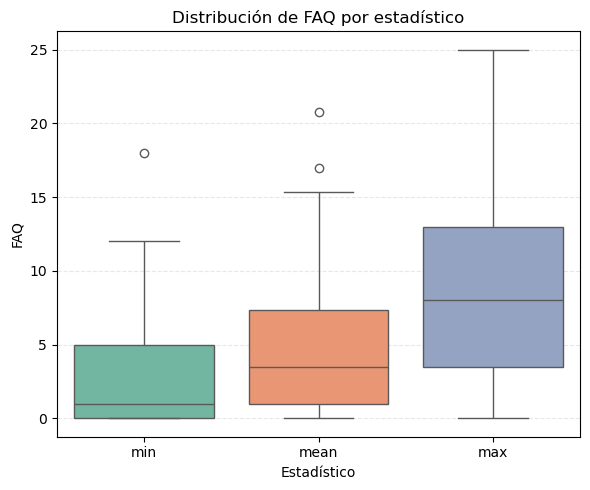

C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


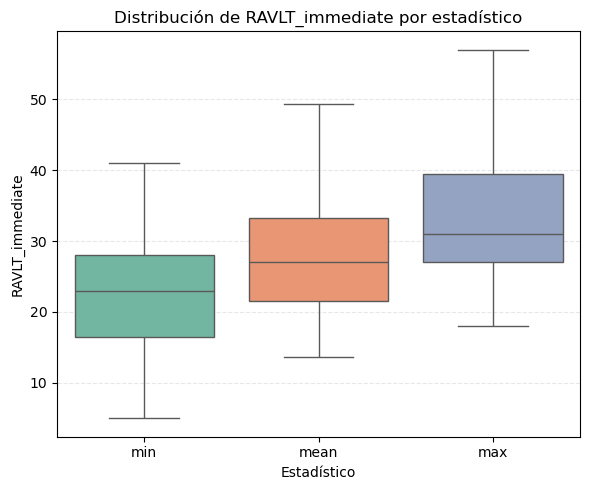

C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


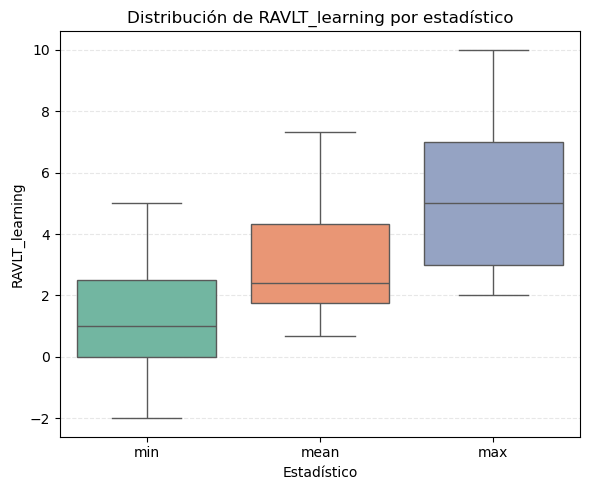

C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


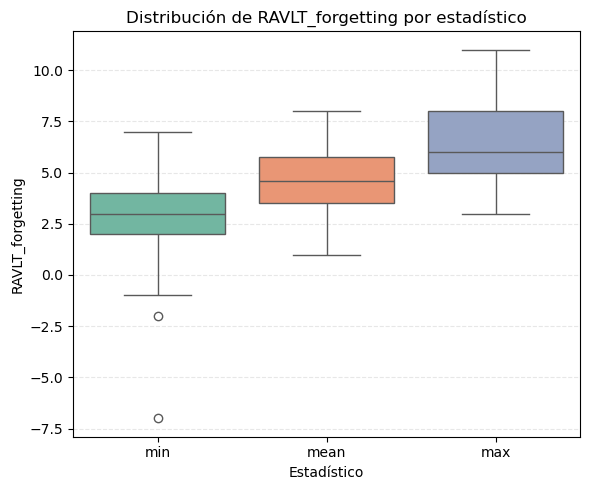

C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


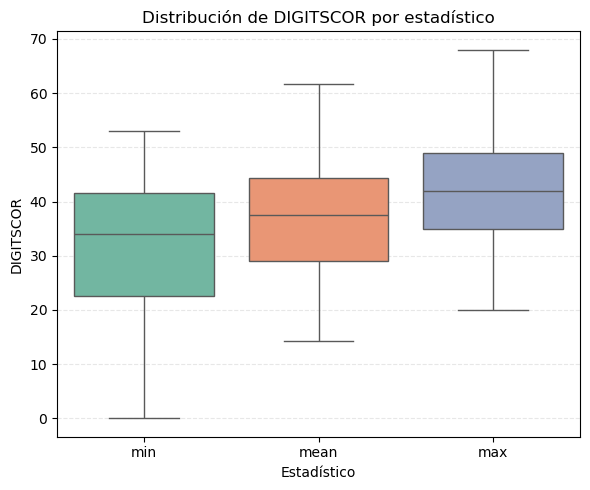

C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


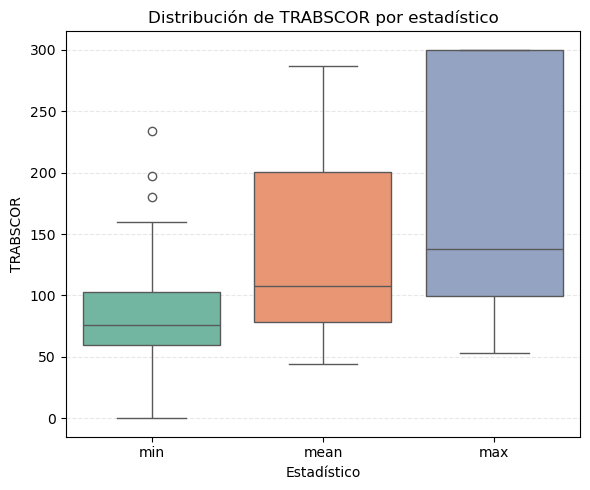

In [27]:
# Aplanar columnas
info_cognitiva.columns = ['sujeto_id'] + [f"{var}_{stat}" for var, stat in info_cognitiva.columns[1:]]

# Convertir a formato largo
info_long = pd.melt(
    info_cognitiva,
    id_vars="sujeto_id",
    var_name="variable_estadistica",
    value_name="valor"
)

# Separar nombre de variable y tipo de estadístico
info_long[["variable", "estadistica"]] = info_long["variable_estadistica"].str.rsplit("_", n=1, expand=True)

variables = info_long["variable"].unique()

for var in variables:
    plt.figure(figsize=(6, 5))
    sns.boxplot(
        data=info_long[info_long["variable"] == var],
        x="estadistica",
        y="valor",
        palette="Set2"
    )
    plt.title(f"Distribución de {var} por estadístico")
    plt.xlabel("Estadístico")
    plt.ylabel(var)
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [28]:
# Agrupar por variable y estadístico
tabla_resumen = info_long.groupby(["variable", "estadistica"])["valor"].agg(["min", "mean", "max"]).round(2).reset_index()
# Ordenar por variable y tipo de estadístico
tabla_resumen = tabla_resumen.sort_values(["variable", "estadistica"])

# Mostrar
tabla_resumen

variable estadistica    min    mean     max
0             ADAS13         max  10.33   25.29   49.33
1             ADAS13        mean   8.33   20.74   36.40
2             ADAS13         min   1.67   16.27   32.33
3              CDRSB         max   0.50    2.98    9.00
4              CDRSB        mean   0.50    1.97    5.00
5              CDRSB         min   0.00    1.06    3.00
6          DIGITSCOR         max  20.00   42.22   68.00
7          DIGITSCOR        mean  14.20   37.28   61.67
8          DIGITSCOR         min   0.00   31.35   53.00
9                FAQ         max   0.00    8.53   25.00
10               FAQ        mean   0.00    5.39   20.80
11               FAQ         min   0.00    2.67   18.00
12              MMSE         max  24.00   28.29   30.00
13              MMSE        mean  15.20   26.11   29.83
14              MMSE         min   8.00   23.75   29.00
15  RAVLT_forgetting         max   3.00    6.29   11.00
16  RAVLT_forgetting        mean   1.00    4.54    8.00
17  RAVLT_forgetting         min  -7.00    2.75    7.00
18   RAVLT_immediate         max  18.00   33.14   57.00
19   RAVLT_immediate        mean  13.60   28.05   49.33
20   RAVLT_immediate         min   5.00   23.27   41.00
21    RAVLT_learning         max   2.00    5.12   10.00
22    RAVLT_learning        mean   0.67    3.19    7.33
23    RAVLT_learning         min  -2.00    1.22    5.00
24          TRABSCOR         max  53.00  178.90  300.00
25          TRABSCOR        mean  44.33  134.41  286.80
26          TRABSCOR         min   0.00   88.12  234.00

* Variables sobre le volumen MRI

In [29]:
# Variables de de Volúmenes MRI
info_volumen = df.groupby('sujeto_id').agg({
    'Ventricles' : ['min', 'mean', 'max'],
    'Hippocampus': ['min', 'mean', 'max'],
    'WholeBrain': ['min', 'mean', 'max'], 
    'Entorhinal': ['min', 'mean', 'max'],
    'Fusiform': ['min', 'mean', 'max'],
    'MidTemp': ['min', 'mean', 'max'],
    'ICV': ['min', 'mean', 'max']
}).reset_index()

C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


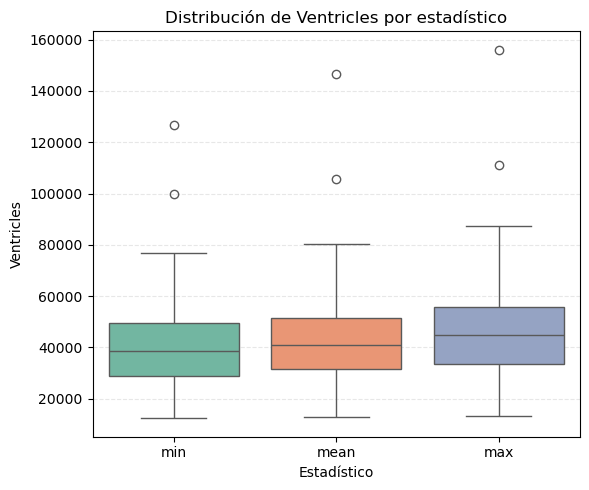

C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


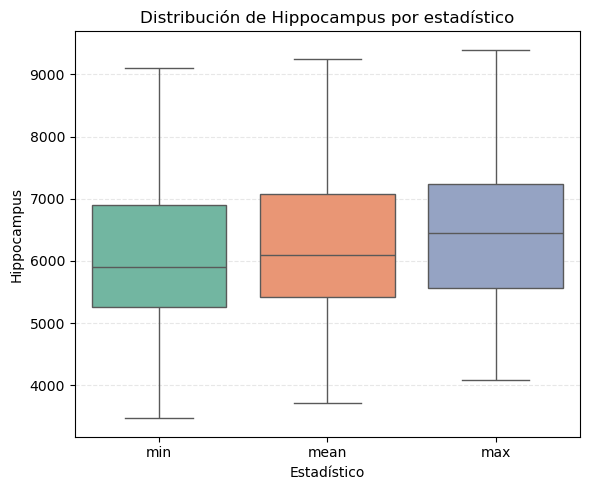

C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


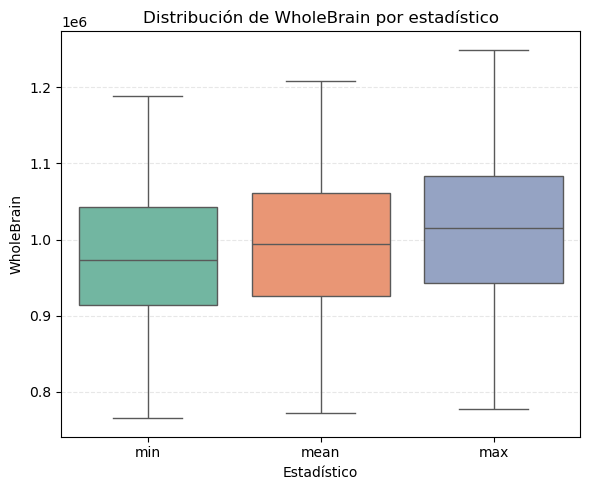

C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


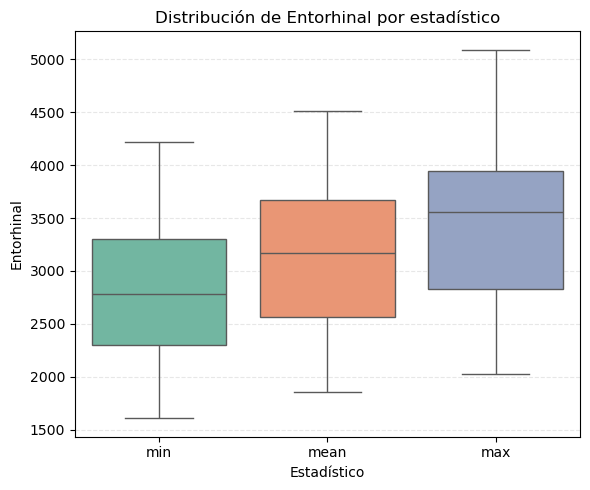

C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


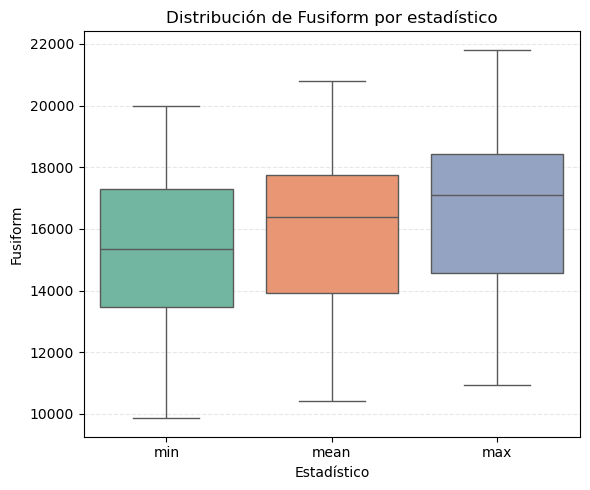

C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


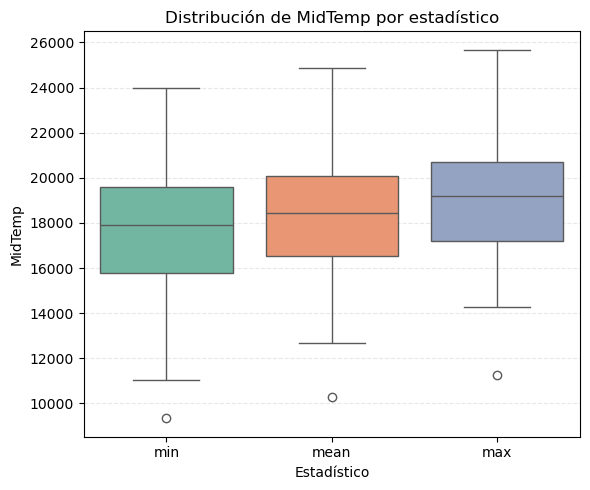

C:\Users\Hp\AppData\Local\Temp\ipykernel_20920\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


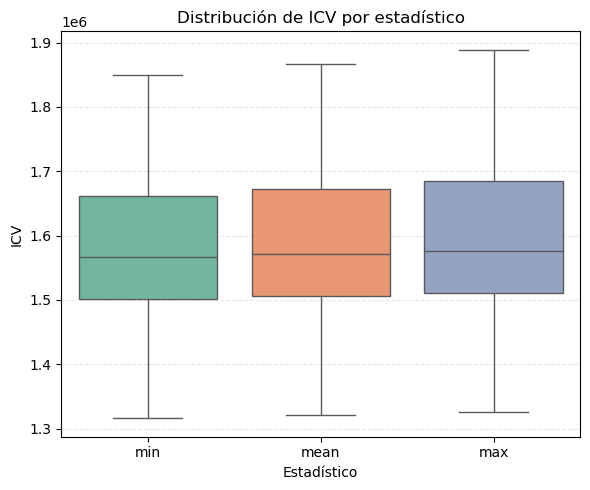

In [30]:
# Aplanar columnas
info_volumen.columns = ['sujeto_id'] + [f"{var}_{stat}" for var, stat in info_volumen.columns[1:]]

# Convertir a formato largo
info_long = pd.melt(
    info_volumen,
    id_vars="sujeto_id",
    var_name="variable_estadistica",
    value_name="valor"
)

# Separar nombre de variable y tipo de estadístico
info_long[["variable", "estadistica"]] = info_long["variable_estadistica"].str.rsplit("_", n=1, expand=True)

variables = info_long["variable"].unique()

for var in variables:
    plt.figure(figsize=(6, 5))
    sns.boxplot(
        data=info_long[info_long["variable"] == var],
        x="estadistica",
        y="valor",
        palette="Set2"
    )
    plt.title(f"Distribución de {var} por estadístico")
    plt.xlabel("Estadístico")
    plt.ylabel(var)
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [31]:
# Agrupar por variable y estadístico
tabla_resumen = info_long.groupby(["variable", "estadistica"])["valor"].agg(["min", "mean", "max"]).round(2).reset_index()
# Ordenar por variable y tipo de estadístico
tabla_resumen = tabla_resumen.sort_values(["variable", "estadistica"])

# Mostrar
tabla_resumen

variable estadistica         min        mean        max
0    Entorhinal         max     2023.00     3481.71     5090.0
1    Entorhinal        mean     1853.00     3157.49     4511.2
2    Entorhinal         min     1608.00     2832.86     4215.0
3      Fusiform         max    10946.00    16742.86    21808.0
4      Fusiform        mean    10424.33    16061.54    20798.8
5      Fusiform         min     9860.00    15365.92    19972.0
6   Hippocampus         max     4087.00     6431.73     9396.0
7   Hippocampus        mean     3717.67     6205.67     9251.5
8   Hippocampus         min     3471.00     5997.59     9102.0
9           ICV         max  1325720.00  1595814.31  1888900.0
10          ICV        mean  1320936.67  1585118.96  1867338.0
11          ICV         min  1315940.00  1575091.76  1850260.0
12      MidTemp         max    11241.00    18991.55    25678.0
13      MidTemp        mean    10291.00    18319.15    24870.0
14      MidTemp         min     9341.00    17627.04    23970.0
15   Ventricles         max    13209.00    48518.61   156066.0
16   Ventricles        mean    12704.00    45054.87   146665.4
17   Ventricles         min    12346.00    41663.00   126585.0
18   WholeBrain         max   777166.00  1012856.61  1249300.0
19   WholeBrain        mean   771940.33   994606.37  1208020.0
20   WholeBrain         min   765255.00   976903.06  1188380.0

* Dx inicial vrs DX final

In [32]:
df_dx = df.sort_values(["sujeto_id", "VISCODE"]).groupby("sujeto_id").agg(
    dx_inicio=("DX", "first"),
    dx_final=("DX", "last")
).reset_index()
tabla_transicion = df_dx.groupby(["dx_inicio", "dx_final"]).size().unstack(fill_value=0)
tabla_transicion

dx_final   Dementia  MCI
dx_inicio               
MCI              22   29

* CLASES A USAR

## Binarias

In [33]:
df_final = df.sort_values(["sujeto_id", "VISCODE"]).groupby("sujeto_id").agg(
    edad_final=("AGE", "last"),
    dx_final=("DX", "last")
).reset_index()
tabla_edad_dx = df_final.groupby("dx_final")["edad_final"].describe().round(1)
tabla_edad_dx


count  mean  std   min   25%   50%   75%   max
dx_final                                                
Dementia   22.0  74.2  6.8  60.3  70.4  74.7  79.2  88.3
MCI        29.0  74.8  7.1  60.7  70.3  75.2  79.4  86.1

* Valores COGNI x VISCODE

In [34]:
df.groupby(["VISCODE"]).mean(numeric_only=True)[[ 'CDRSB', 'MMSE', 'ADAS13', 'FAQ', 'RAVLT_immediate', 'RAVLT_learning',
       'RAVLT_forgetting', 'DIGITSCOR', 'TRABSCOR']]


CDRSB       MMSE     ADAS13       FAQ  RAVLT_immediate  \
VISCODE                                                              
0        1.235294  27.372549  19.078627  3.500000        29.862745   
6        1.627451  26.411765  19.467400  4.352941        28.137255   
12       1.941176  26.333333  20.157451  5.360000        28.627451   
18       2.348837  25.581395  22.200930  6.116279        27.714286   
24       2.837838  24.815789  23.491842  7.837838        26.447368   
30            NaN        NaN        NaN       NaN              NaN   
36       2.812500  25.647059  21.372353  7.235294        27.529412   

         RAVLT_learning  RAVLT_forgetting  DIGITSCOR    TRABSCOR  
VISCODE                                                           
0              3.745098          4.960784  37.725490  120.220000  
6              3.254902          4.529412  38.882353  118.755102  
12             3.235294          4.490196  36.901961  135.843137  
18             2.714286          4.476190  37.069767  137.465116  
24             2.552632          4.736842  35.289474  160.684211  
30                  NaN               NaN        NaN         NaN  
36             3.352941          4.687500  38.562500  151.176471

* Valores VOLUMEN x VISCODE

In [35]:
df.groupby(["VISCODE"]).mean(numeric_only=True)[[ 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp',
       'ICV']]

Ventricles  Hippocampus    WholeBrain   Entorhinal      Fusiform  \
VISCODE                                                                       
0        42340.960784  6410.680851  1.004484e+06  3310.191489  16595.851064   
6        43703.612245  6197.930233  9.968302e+05  3152.511628  16317.046512   
12       45051.313725  6266.659091  9.957942e+05  3211.750000  16089.818182   
18       48546.780488  6185.184211  9.920210e+05  3090.815789  16028.815789   
24       49118.617647  5985.392857  9.839078e+05  3093.571429  15676.285714   
30                NaN          NaN           NaN          NaN           NaN   
36       43194.400000  6010.833333  9.965634e+05  3006.333333  15955.166667   

              MidTemp           ICV  
VISCODE                              
0        18974.000000  1.582249e+06  
6        18627.395349  1.585129e+06  
12       18337.409091  1.585502e+06  
18       17961.078947  1.587287e+06  
24       18249.607143  1.592065e+06  
30                NaN           NaN  
36       18281.166667  1.589993e+06

## Evolución por visita

In [36]:
tabla_dx = df.pivot_table(
    index="sujeto_id",
    columns="VISCODE",
    values="DX",
    aggfunc="first"  # Asume que hay una sola entrada por sujeto-visita
).fillna("-") 
tabla_dx

VISCODE      0         6         12        18        24        36
sujeto_id                                                        
007_S_0101  MCI       MCI       MCI       MCI  Dementia  Dementia
007_S_0128  MCI       MCI       MCI  Dementia  Dementia         -
007_S_0249  MCI       MCI  Dementia  Dementia  Dementia  Dementia
013_S_0240  MCI       MCI       MCI  Dementia         -         -
014_S_0169  MCI       MCI       MCI       MCI       MCI       MCI
018_S_0057  MCI       MCI       MCI  Dementia  Dementia         -
018_S_0080  MCI       MCI       MCI         -         -         -
018_S_0087  MCI       MCI       MCI       MCI         -         -
018_S_0142  MCI       MCI       MCI       MCI       MCI         -
018_S_0155  MCI       MCI       MCI       MCI       MCI         -
021_S_0141  MCI       MCI  Dementia  Dementia  Dementia         -
021_S_0231  MCI       MCI       MCI       MCI  Dementia  Dementia
021_S_0273  MCI       MCI       MCI       MCI       MCI         -
021_S_0276  MCI       MCI       MCI       MCI       MCI       MCI
022_S_0004  MCI       MCI       MCI       MCI         -         -
023_S_0042  MCI       MCI  Dementia  Dementia  Dementia  Dementia
023_S_0126  MCI       MCI       MCI       MCI       MCI  Dementia
027_S_0116  MCI       MCI       MCI       MCI       MCI       MCI
027_S_0179  MCI       MCI       MCI  Dementia         -         -
027_S_0256  MCI  Dementia  Dementia  Dementia  Dementia  Dementia
027_S_0307  MCI       MCI       MCI       MCI       MCI       MCI
032_S_0187  MCI       MCI       MCI       MCI  Dementia         -
032_S_0214  MCI       MCI       MCI       MCI  Dementia  Dementia
035_S_0033  MCI       MCI       MCI       MCI       MCI       MCI
035_S_0204  MCI       MCI  Dementia  Dementia  Dementia         -
035_S_0292  MCI       MCI       MCI       MCI         -         -
037_S_0150  MCI       MCI       MCI       MCI       MCI         -
041_S_0282  MCI       MCI       MCI       MCI         -         -
067_S_0038  MCI       MCI       MCI         -         -         -
067_S_0077  MCI       MCI  Dementia  Dementia  Dementia         -
067_S_0098  MCI       MCI       MCI         -       MCI         -
067_S_0176  MCI       MCI       MCI         -       MCI         -
098_S_0160  MCI       MCI       MCI       MCI       MCI         -
098_S_0269  MCI  Dementia  Dementia  Dementia  Dementia         -
099_S_0051  MCI       MCI       MCI       MCI       MCI         -
099_S_0054  MCI       MCI  Dementia  Dementia  Dementia         -
099_S_0060  MCI       MCI       MCI         -         -         -
099_S_0111  MCI       MCI  Dementia         -         -         -
099_S_0291  MCI       MCI       MCI         -         -         -
100_S_0006  MCI       MCI       MCI       MCI       MCI       MCI
100_S_0296  MCI       MCI       MCI       MCI       MCI         -
123_S_0108  MCI       MCI       MCI  Dementia  Dementia  Dementia
128_S_0188  MCI       MCI       MCI         -         -         -
128_S_0200  MCI       MCI       MCI       MCI         -         -
128_S_0225  MCI       MCI       MCI       MCI       MCI       MCI
128_S_0258  MCI       MCI       MCI       MCI  Dementia         -
130_S_0102  MCI       MCI       MCI       MCI       MCI         -
130_S_0285  MCI       MCI       MCI       MCI       MCI       MCI
130_S_0289  MCI       MCI       MCI       MCI  Dementia         -
136_S_0107  MCI       MCI       MCI       MCI       MCI       MCI
136_S_0195  MCI       MCI  Dementia  Dementia  Dementia         -